![ed-5](ed-5.png "Title")
<center><h1>The Lyrics of Ed Sheeran's Songs</h1></center>
<center><h2>A Data Visualisation Exercise</h2></center>

# Abstract
Ed Sheeran is one of the hottest artists today (2019). He is the second artist to have 4 songs [cross 1 billion streams on Spotify](https://www.forbes.com/sites/hughmcintyre/2019/01/18/ed-sheeran-is-the-second-musician-to-see-four-hits-reach-one-billion-streams-on-spotify/#23b5263e5319). In this exercise, I want to see his songwriting prowess, in particular the lyrics he uses in his songs. 

Most of his songs revolve around love like Perfect, Thinking Out Loud and Shape of You. Hence, I expect to see many words that are related to these themes.

# Data Collection

In [1]:
import re
from collections import OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

sns.set()

In [2]:
# Read from CSV file
df = pd.read_csv('ed-sheeran-lyrics-1.csv', sep='|')
df.drop(64, axis=0, inplace=True)
df.drop_duplicates(subset='title', keep='first', inplace=True)
songs_wanted = [
    # +
    'the-a-team', 'drunk', 'uni', 'grade-8', 'wake-me-up', 'small-bump', 
    'this', 'lego-house', 'kiss-me', 'give-me-love', 
    # x
    'one', 'im-a-mess', 'sing', 'dont', 'nina', 'photograph', 'bloodstream', 
    'tenerife-sea', 'runaway', 'the-man', 'thinking-out-loud', 'afire-love', 
    # ÷
    'eraser', 'castle-on-the-hill', 'dive', 'shape-of-you', 'perfect', 
    'galway-girl', 'happier', 'new-man', 'hearts-dont-break-around-here', 
    'what-do-i-know', 'how-would-you-feel-paean', 'supermarket-flowers', 'barcelona', 
    'bibia-be-ye-ye', 'nancy-mulligan', 'save-myself']
print(len(songs_wanted))
df = df[df['title'].isin(songs_wanted)]
df.reset_index(drop=True, inplace=True)
print(df.shape)

38
(38, 2)


## Text Normalisation

We shall perform the simplest normalisation techniques on our words. The first step is to:

1. convert them all to lower case
2. remove trailing and leading spaces

This can be done via a `lambda` function.

In [3]:
df['lyrics_step1'] = df['lyrics'].apply(lambda x : x.lower().strip())

Let's see what happens to the lyrics after the normalisation.

In [4]:
s = df.iloc[19] # or df.sample()
print(s['title'])
print('---')
print(s['lyrics'].strip()[:500])
print('---')
print(s['lyrics_step1'][:500])

the-man
---
No, I don't wanna hate you Just wish you'd never gone for the man And waited two weeks at least Before you let him take you I stayed true I kind of knew you liked the dude from private school He's waiting for the time to move I knew he had his eyes on you He's not the right guy for you Don't hate me cause I write the truth No I would never lie to you But it was never fine to lose you And what a way to find out It never came from my mouth You never changed your mind But you were just afraid to mi
---
no, i don't wanna hate you just wish you'd never gone for the man and waited two weeks at least before you let him take you i stayed true i kind of knew you liked the dude from private school he's waiting for the time to move i knew he had his eyes on you he's not the right guy for you don't hate me cause i write the truth no i would never lie to you but it was never fine to lose you and what a way to find out it never came from my mouth you never changed your mind but you were 

Let's take a look at another song - Shape of You.

In [5]:
s = df[df['title'] == 'shape-of-you'].iloc[0]
print(s['title'])
print('---')
print(s['lyrics'].strip()[:500])
print('---')
print(s['lyrics_step1'][:500])

shape-of-you
---
The club isn't the best place to find a lover So the bar is where I go (mmmm) Me and my friends at the table doing shots Drinking fast and then we talk slow (mmmm) And you come over and start up a conversation with just me And trust me I'll give it a chance now (mmmm) Take my hand, stop, put Van The Man on the jukebox And then we start to dance And now I'm singing like  Girl, you know I want your love Your love was handmade for somebody like me Come on now, follow my lead I may be crazy, don't m
---
the club isn't the best place to find a lover so the bar is where i go (mmmm) me and my friends at the table doing shots drinking fast and then we talk slow (mmmm) and you come over and start up a conversation with just me and trust me i'll give it a chance now (mmmm) take my hand, stop, put van the man on the jukebox and then we start to dance and now i'm singing like  girl, you know i want your love your love was handmade for somebody like me come on now, follow my lead i

It looks like we might need to do more in the special characters removal department. 

In [6]:
all_lyrics_str = ' '.join(df['lyrics_step1'].tolist())
all_lyrics_str = all_lyrics_str.encode('ascii', 'ignore').decode() #remove non-ascii characters

all_lyrics = all_lyrics_str.split()
print(len(all_lyrics)) # There are 14987 lyrics in these 38 songs.

all_lyrics_set = set(all_lyrics)
print(len(all_lyrics_set)) # Of which there are only 2005 unique words.

14987
2005


As you can see, we find words that do not start with alphabets **OR** do not end with alphabets. For these words, we use a simple regex expression to remove the special characters. These include punctuation marks and parentheses. Observe how the word is transformed.

In [7]:
for w in list(all_lyrics_set)[:100]: # Remove the index to see the full list of words transformed.
    if not(re.search("^\w", w) is not None and re.search("\w$", w) is not None):
        print("BEFORE: %s |AFTER: %s" % (w, re.sub('\W', '', w)))

BEFORE: changes, |AFTER: changes
BEFORE: else, |AFTER: else
BEFORE: t, |AFTER: t
BEFORE: lord, |AFTER: lord
BEFORE: hallelujah, |AFTER: hallelujah
BEFORE: (everything |AFTER: everything
BEFORE: drive, |AFTER: drive
BEFORE: three, |AFTER: three
BEFORE: forget, |AFTER: forget
BEFORE: sinking, |AFTER: sinking
BEFORE: nina, |AFTER: nina
BEFORE: change, |AFTER: change
BEFORE: dance" |AFTER: dance
BEFORE: sunset, |AFTER: sunset


In [8]:
# Perform the removal of special characters according to above rule
all_lyrics2 = [re.sub('\W', '', w) 
               if not(re.search("^\w", w) is not None and re.search("\w$", w) is not None) 
               else w 
               for w in all_lyrics]
print(len((all_lyrics2))) # Now there are only 1764 unique words, instead of 2005
print(len(set(all_lyrics2))) # Now there are only 1764 unique words, instead of 2005
print(len((all_lyrics2))/len(set(all_lyrics2)))

14987
1764
8.496031746031745


Let's consider some numerical facts about these words. If there are 14987 terms and 1764 unique terms, then on average there are 8.5 occurences of each word. However, the most occuring words have up to almost 600 occurences. Hence, they clearly skew the distribution by a lot.

In [9]:
w_df = pd.DataFrame(all_lyrics2, columns=['wd'])
w_df_agg = w_df.groupby('wd').size().reset_index(name='n')
w_df_agg.sort_values('n', ascending=False, inplace=True)
m = 50
print("Top %d most common words" % m)
l = []
for i in w_df_agg[:m].iterrows():
    l.append((i[1]['wd'],(i[1]['n'])))
print(l)

Top 50 most common words
[('i', 597), ('you', 490), ('the', 486), ('and', 476), ('my', 474), ('me', 308), ('in', 289), ('to', 279), ('love', 265), ('a', 250), ('on', 181), ('your', 180), ('of', 153), ('that', 145), ('but', 145), ('it', 144), ("i'm", 140), ('be', 139), ('with', 134), ('know', 130), ("i'll", 123), ('now', 120), ("don't", 107), ('oh', 101), ('all', 101), ('for', 100), ('we', 97), ('just', 96), ('so', 86), ('when', 75), ('this', 74), ('up', 71), ('like', 71), ('never', 69), ("you're", 67), ('out', 66), ('is', 64), ("i've", 63), ('one', 60), ('ye', 60), ('if', 60), ('wanna', 60), ('baby', 59), ('come', 58), ('cause', 57), ('down', 56), ('give', 53), ('can', 53), ('was', 52), ('she', 51)]


Let's just see the words that have only one occurence in all his songs.

In [10]:
m = 30 # There are a lot more. Modify this value to see them.
print("Top %d most common words, frequency in descending order" % m)
l = []
for i in w_df_agg[w_df_agg['n']<=1][:m].iterrows(): 
    l.append((i[1]['wd']))
print(l)

Top 30 most common words, frequency in descending order
['build', 'speakers', 'splattered', 'wo-ooooahhhh', 'spirits', 'spiral', 'sorry', 'spliff', 'cap', 'ages', 'spinning', 'woke', 'sparks', 'sparkle', 'word', 'cans', 'acting', 'southern', 'streak', 'burnt', 'adore', 'stood', 'wishing', 'afternoon', 'stopped', 'wiped', 'windowsill', 'stool', 'stones', 'spoke']


Let's plot a wordcloud using the wordcloud library of all the lyrics of Ed Sheeran. The larger the word, the more frequent it is used in his songs.

Clue: Download fonts in `.ttf` format so you can use them in your wordcloud.

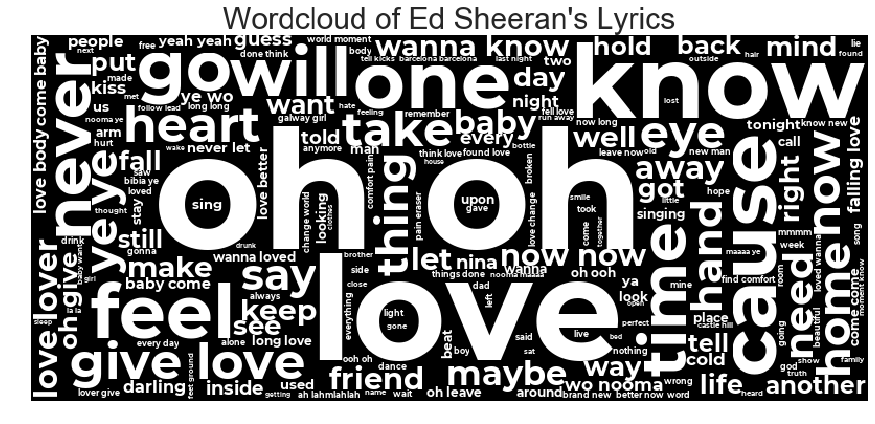

In [11]:
v = ' '.join(all_lyrics2)
# Create the wordcloud
plt.figure(figsize=(15,12))
desc_wordcloud = WordCloud(font_path="Montserrat-Bold.ttf", width=800, height=350, 
                           background_color='black', relative_scaling = 0.5, color_func=lambda *args, **kwargs: "white", 
                           max_words=200, collocations=True, stopwords=None).generate(v)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of Ed Sheeran's Lyrics", fontsize=30)
plt.show()

A few things come to mind:
1. `oh oh` is shown there because the wordcloud also considers frequency of bigrams. To remove that, use `collocations=False`.

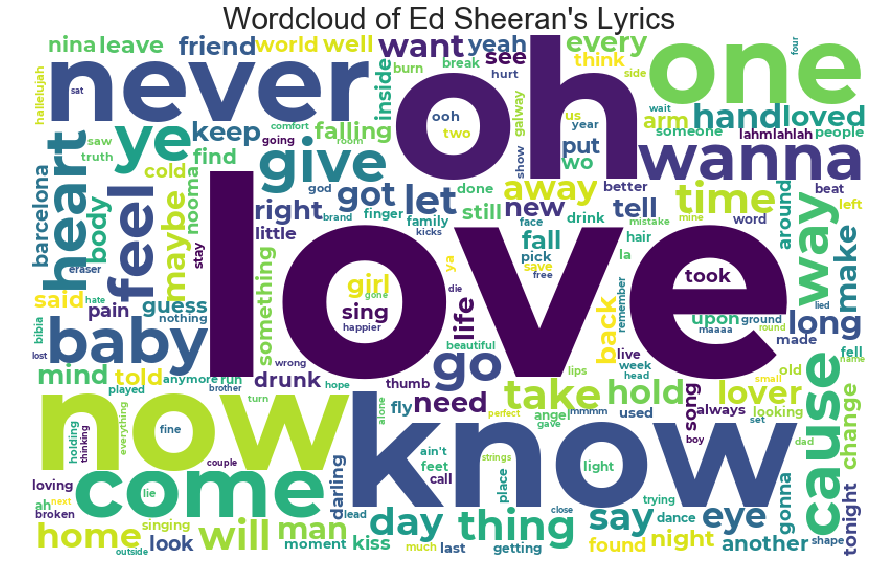

In [12]:
v = ' '.join(all_lyrics2)
# Create the wordcloud
plt.figure(figsize=(15,12))
desc_wordcloud = WordCloud(font_path="Montserrat-Bold.ttf", width=800, height=500, 
                           background_color='white', relative_scaling = 0.5,
                           max_words=200, collocations=False, stopwords=None).generate(v)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of Ed Sheeran's Lyrics", fontsize=30)
plt.show()

In [14]:
total_oh, total_love = 0, 0
for idx, r in df.iterrows():
    t, l = r['title'], r['lyrics_step1']
    count_oh, count_love = 0, 0
    for ly in l.split():
        if ly.lower() == 'oh':
            count_oh +=1
        elif ly.lower() == 'love':
            count_love +=1            
    print('%30s - oh=%d,love=%d' % (t, count_oh, count_love))  
    total_oh += count_oh
    total_love += count_love
print('oh=%d,love=%d' % (total_oh, total_love))  

                    the-a-team - oh=0,love=3
                         drunk - oh=0,love=5
                           uni - oh=0,love=3
                       grade-8 - oh=2,love=0
                    wake-me-up - oh=0,love=7
                    small-bump - oh=0,love=0
                          this - oh=0,love=0
                    lego-house - oh=0,love=15
                       kiss-me - oh=1,love=16
                  give-me-love - oh=19,love=5
                           one - oh=0,love=1
                     im-a-mess - oh=2,love=16
                          sing - oh=0,love=5
                          dont - oh=0,love=6
                          nina - oh=13,love=3
                    photograph - oh=1,love=2
                   bloodstream - oh=0,love=0
                  tenerife-sea - oh=0,love=9
                       runaway - oh=0,love=4
                       the-man - oh=0,love=12
             thinking-out-loud - oh=0,love=9
                    afire-love - oh=4,love=8
    

In [16]:
df[df['title'].isin(['shape-of-you', 'give-me-love'])]['lyrics_step1'].tolist()

["give me love like her, 'cause lately i've been waking up alone, paint splattered teardrops on my shirt, told you i'd let them go,  and that i'll fight my corner, maybe tonight i'll call ya, after my blood turns into alcohol, no, i just wanna hold ya.  give a little time to me or burn this out, we'll play hide and seek to turn this around, all i want is the taste that your lips allow, my, my, my, my, oh give me love, my, my, my, my, oh give me love, my, my, my, my, oh give me love, my, my, my, my, oh give me love, my, my, my, my, give me love,  give me love like never before, 'cause lately i've been craving more, and it's been a while but i still feel the same, maybe i should let you go,  you know i'll fight my corner, and that tonight i'll call ya, after my blood is drowning in alcohol, no, i just wanna hold ya.  give a little time to me or burn this out, we'll play hide and seek to turn this around, all i want is the taste that your lips allow, my, my, my, my, oh give me love,  give